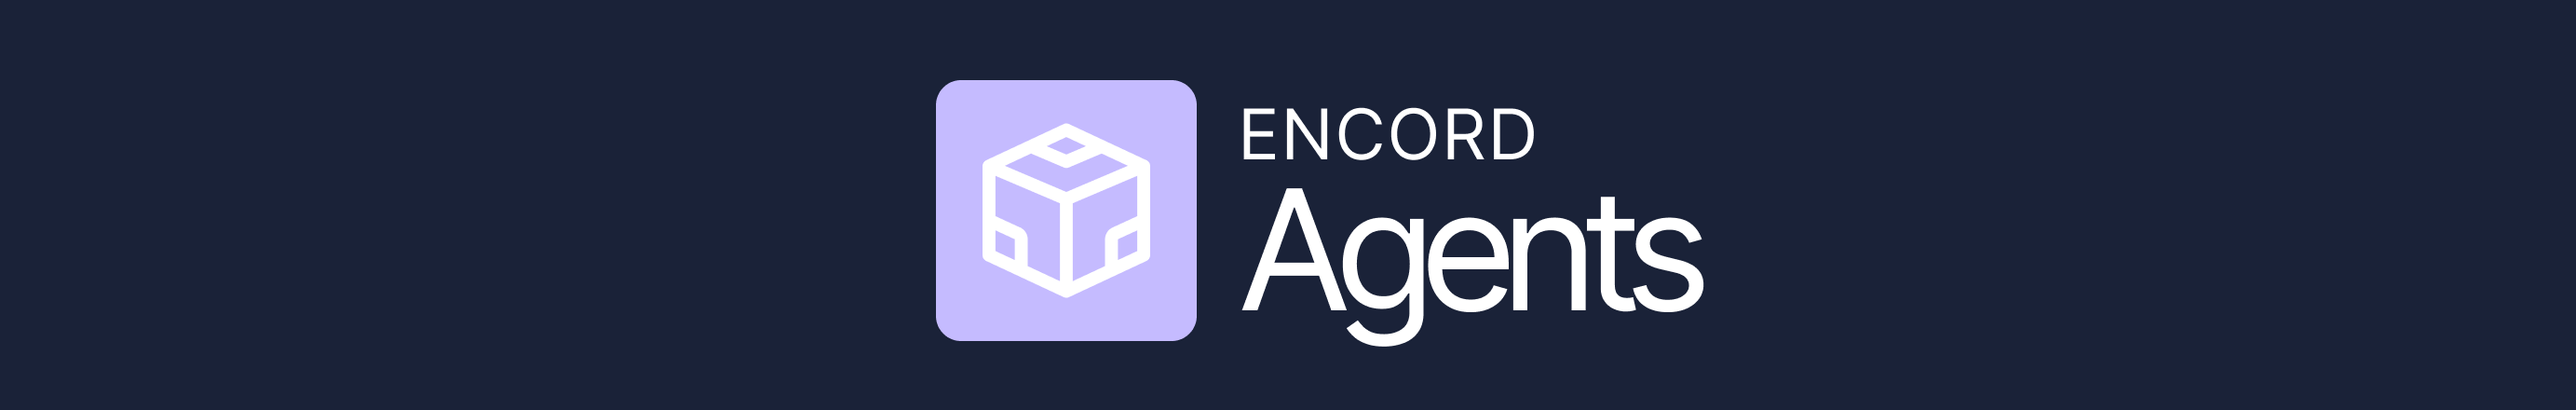


# Use a Hugging Face 🤗 Model

This notebook demonstrates how to use a task agent to pre-label videos with predictions. A bounding box prediction model is used.


## Requirements

This notebook guides you through the Workflow template, Ontology and model selection required.

For this notebook, you need: 
 
- A Dataset containing visual files (video, images, image groups, or image sequences)in Encord. 
- Access to Hugging Face models.

## Installation

Ensure that you have the `encord-agents` library installed.

In [ ]:
!python -m pip install encord-agents[opencv-headless]

## Encord Authentication

Encord uses ssh-keys for authentication. The following is a code cell for setting the `ENCORD_SSH_KEY` environment variable. It contains the raw content of your private ssh key file.

If you have not setup an ssh key, see our [documentation](https://agents-docs.encord.com/authentication/).

> 💡 In colab, you can set the key once in the secrets in the left sidebar and load it in new notebooks. IF YOU ARE NOT RUNNING THE CODE IN THE COLLAB NOTEBOOK, you must set the environment variable directly.
> ```python
> os.environ["ENCORD_SSH_KEY"] = """paste-private-key-here"""
> ```

In [ ]:
from google.colab import userdata

key_contet = userdata.get("ENCORD_SSH_KEY")

In [ ]:
import os

os.environ["ENCORD_SSH_KEY"] = key_contet
# or you can set a path to a file
# os.environ["ENCORD_SSH_KEY_FILE"] = "/path/to/your/private/key"

#### [Alternative] Temporary Key
There's also the option of generating a temporary (fresh) ssh key pair via the code cell below.
Please follow the instructions printed when executing the code.

In [ ]:
# ⚠️ Safe to skip if you have authenticated already
import os

from encord_agents.utils.colab import generate_public_private_key_pair_with_instructions

private_key_path, public_key_path = generate_public_private_key_pair_with_instructions()
os.environ["ENCORD_SSH_KEY_FILE"] = private_key_path.as_posix()

## Define a Model for Predictions

Define a model to predict labels, bounding boxes, and confidence scores.  

This model will identify objects in video frames by predicting their classifications, locations, and associated confidence levels. We'll use the DETR model from Hugging Face, as outlined in the following article:
https://huggingface.co/docs/transformers/en/model_doc/detr

Other models are available from: https://huggingface.co/models

> 💡 If you want to use a different model, such as your own model from Hugging Face, the following code blocks should be modified.


In [ ]:
import requests
import torch
from PIL import Image
from transformers import DetrForObjectDetection, DetrImageProcessor

url = "http://images.cocodataset.org/val2017/000000039769.jpg"
image = Image.open(requests.get(url, stream=True).raw)

# You can specify the revision tag if you don't want the timm dependency
processor = DetrImageProcessor.from_pretrained("facebook/detr-resnet-50", revision="no_timm")
model = DetrForObjectDetection.from_pretrained("facebook/detr-resnet-50", revision="no_timm")

inputs = processor(images=image, return_tensors="pt")
outputs = model(**inputs)

# Convert outputs (bounding boxes and class logits) to COCO API
# Only keep detections with score > 0.9
target_sizes = torch.tensor([image.size[::-1]])
results = processor.post_process_object_detection(outputs, target_sizes=target_sizes, threshold=0.9)[0]

for score, label, box in zip(results["scores"], results["labels"], results["boxes"]):
    box = [round(i, 2) for i in box.tolist()]
    print(
        f"Detected {model.config.id2label[label.item()]} with confidence " f"{round(score.item(), 3)} at location {box}"
    )

### Define the Agent

Once the model is defined it is time to define the agent.

In [ ]:
from dataclasses import dataclass

import numpy as np
from encord.objects.coordinates import BoundingBoxCoordinates
from numpy.typing import NDArray


# Data class to hold predictions from our model
@dataclass
class ModelPrediction:
    featureHash: str
    coords: BoundingBoxCoordinates
    conf: float


def HF_DETR_predict(image: NDArray[np.uint8]) -> list[ModelPrediction]:
    inputs = processor(images=image, return_tensors="pt")
    outputs = model(**inputs)

    target_sizes = torch.tensor([image.shape[:2]])
    results = processor.post_process_object_detection(outputs, target_sizes=target_sizes)[0]
    model_predictions = []
    for score, label, box in zip(results["scores"], results["labels"], results["boxes"]):
        box = [round(i, 2) for i in box.tolist()]
        # We'll skip predictions with confidence < 0.8
        # As this model makes a lot of predictions
        if score < 0.8:
            continue
        print(
            f"Detected {model.config.id2label[label.item()]} with confidence "
            f"{round(score.item(), 3)} at location {box}"
        )
        if ontology_equivalent := ontology_map.get(model.config.id2label[label.item()]):
            model_predictions.append(
                ModelPrediction(
                    featureHash=ontology_equivalent,
                    coords=BoundingBoxCoordinates(top_left_x=box[0], top_left_y=box[1], width=box[2], height=box[3]),
                    conf=score.item(),
                )
            )
    return model_predictions


agent = HF_DETR_predict

## Set Up Ontology

Create an Ontology in Encord that matches the expected output of your pre-labeling agent. For example, if your model predicts classes `surfboard`, `person`, and `car`, then the Ontology should match the ONtology shown below. The DETR model we use can predicts more objects, but in this example our focus is on the car predictions.

<figure style="text-align: center">
  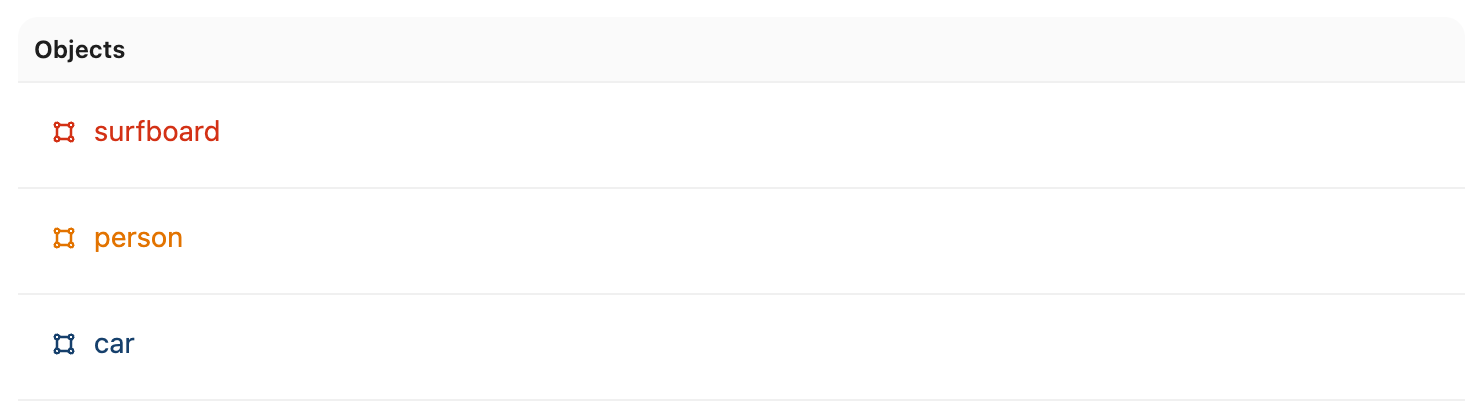
  <figcaption><stong>Figure 1:</strong> Project ontology.</figcaption>
</figure>

[📖 Here](https://docs.encord.com/platform-documentation/GettingStarted/gettingstarted-create-ontology) is the documentation for creating Ontologies.

### Define an Ontology Map

We need to translate the model predictions so that they are paired against the respective Encord ontology item. This is easiest done via the featureNodeHash of the target. This can be found in the app either via the Ontology preview JSON or via using the SDK.

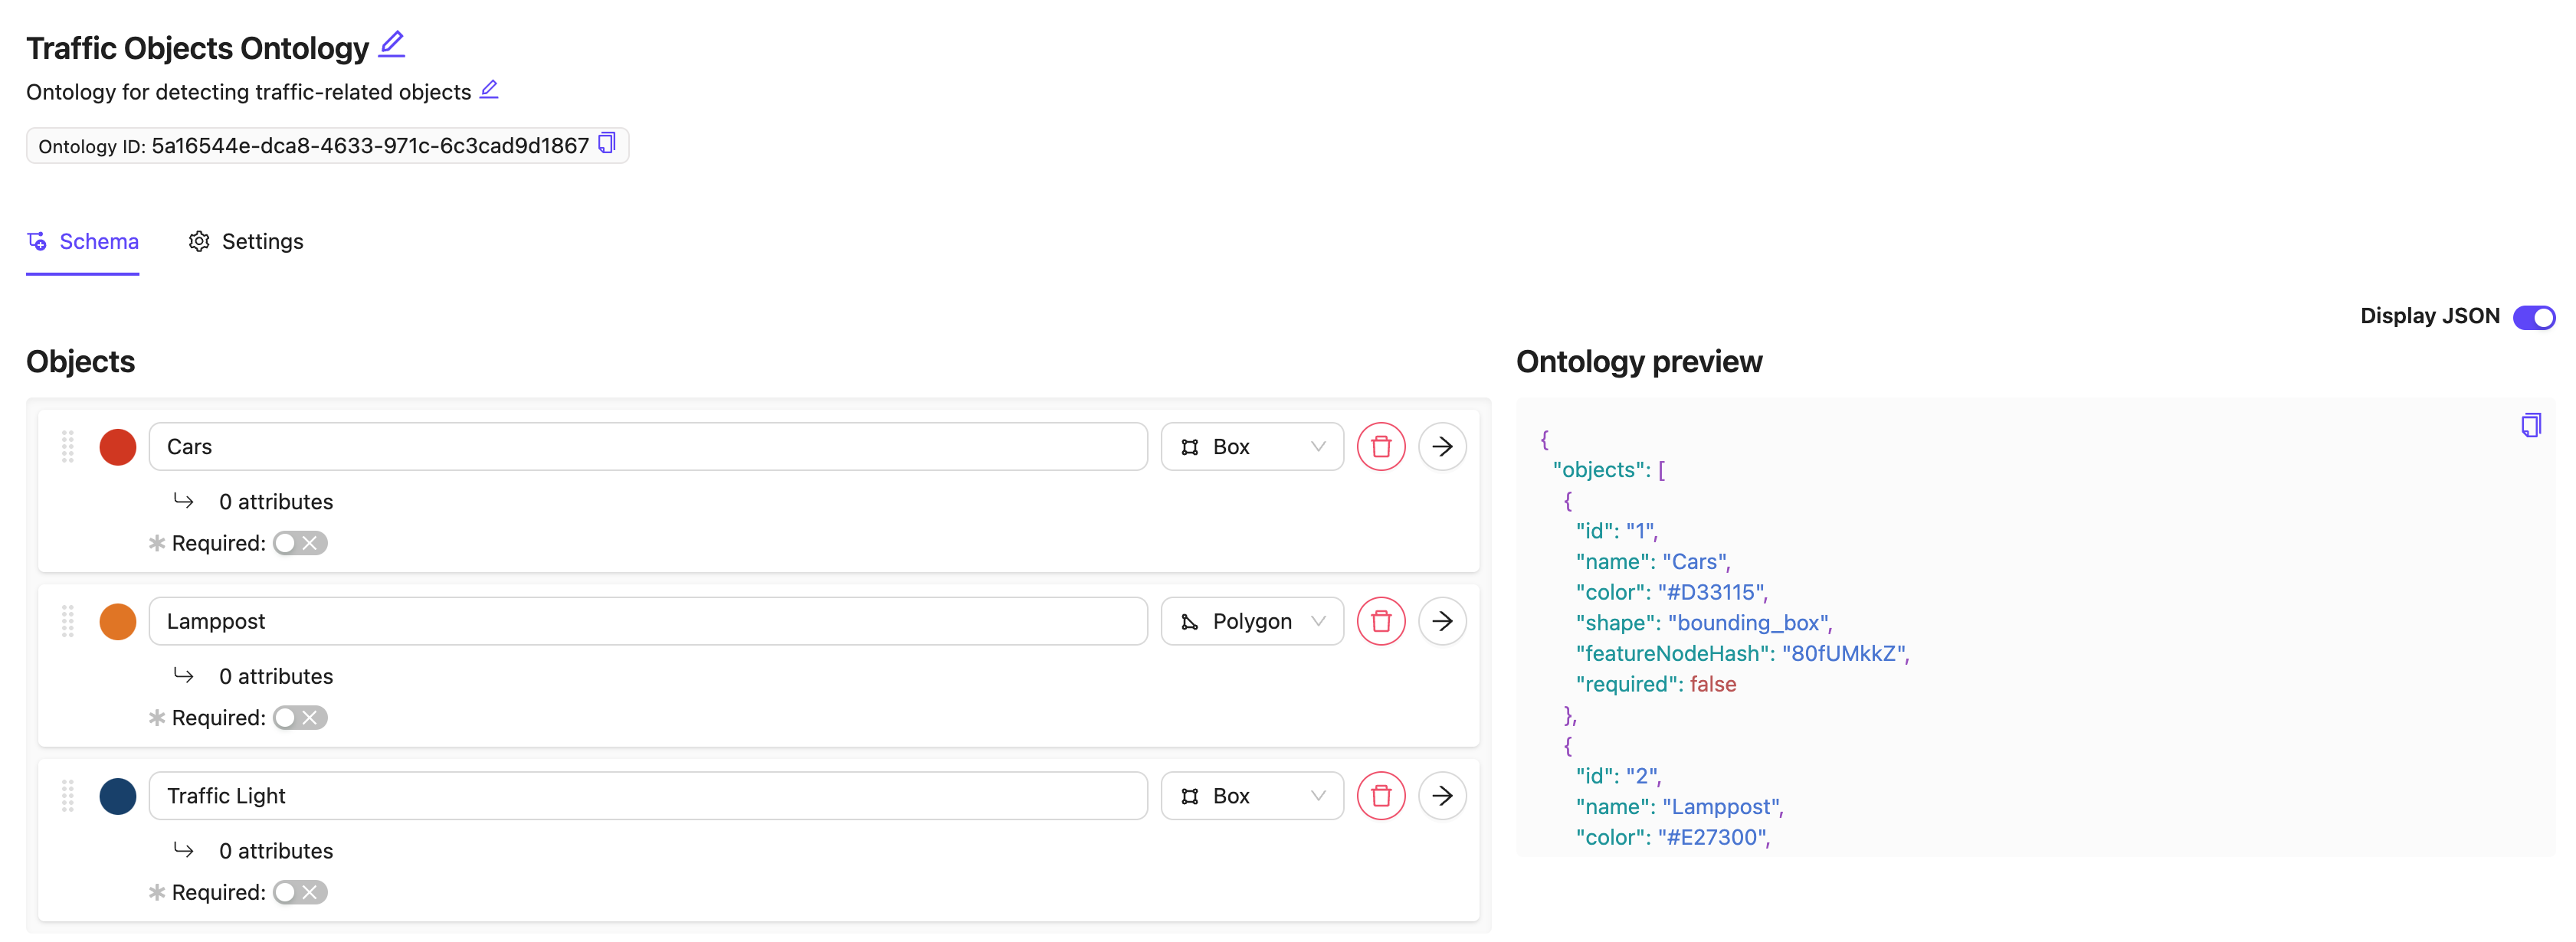

In [ ]:
ontology_map = {"car": "80fUMkkZ"}
# Note the featureNodeHash as seen on the right hand side above

## Create a Workflow with a Pre-Labeling Agent Node

Create a Project in the Encord platform with a workflow that includes a pre-labeling agent node before the annotation stage. This node, called **"pre-label,"** runs custom code to generate model predictions, automatically pre-labeling tasks before they are sent for annotation.

[📖 Here](https://docs.encord.com/platform-documentation/Annotate/annotate-projects/annotate-workflows-and-templates#creating-workflows) is the documentation for creating Workflows in Encord.

<figure style="text-align: center">
  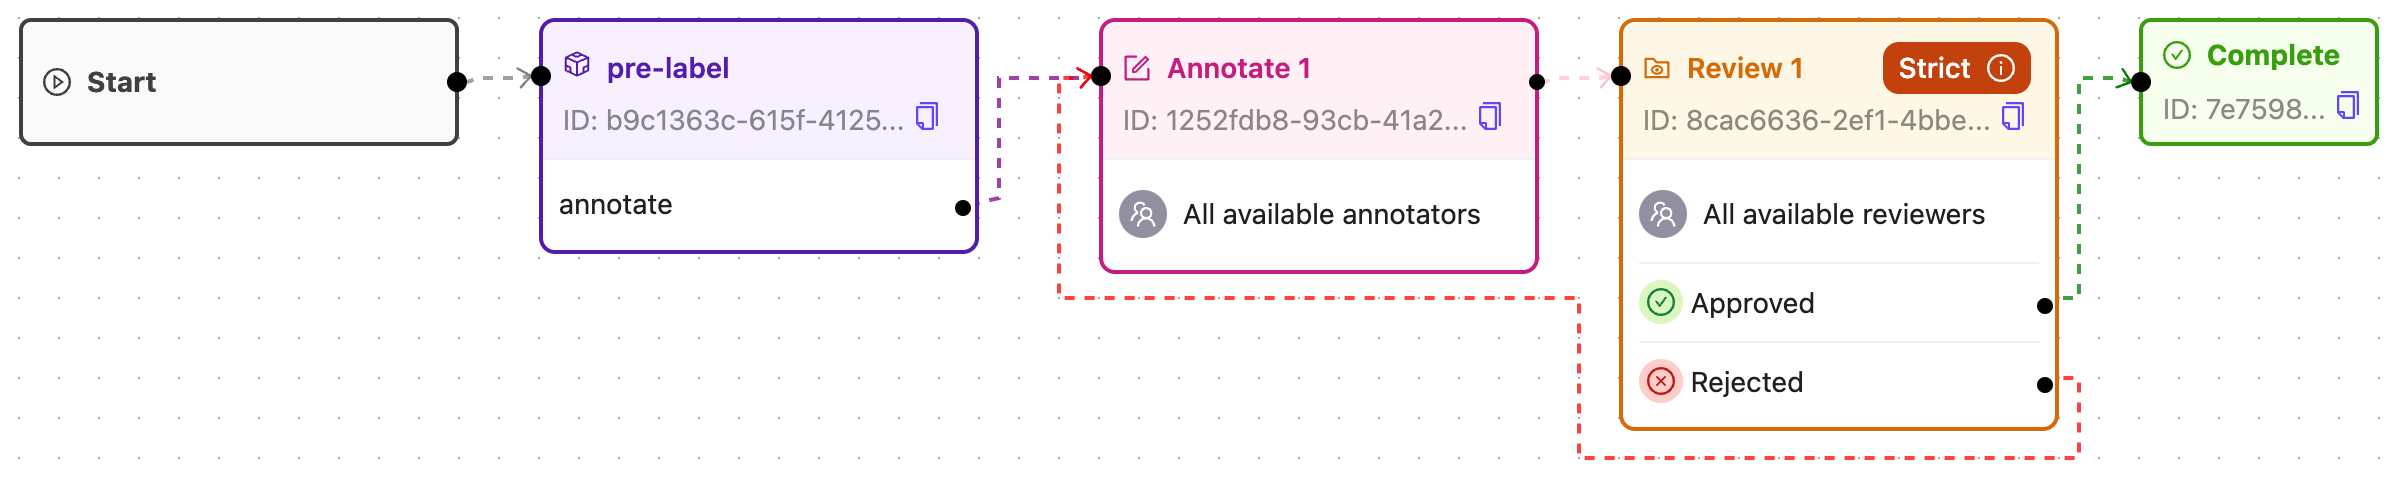
  <figcaption><strong>Figure 2:</strong> Project workflow.</figcaption>
</figure>

## Define the Pre-Labeling Agent

The following code serves as a template for defining a pre-labeling agent.  

It assumes the project contains only videos and applies pre-labeling to all frames in each video.  

If the agent node is named **"pre-label"** and the pathway to the annotation stage is **"annotate,"** simply replace `<project_hash>` with your actual project hash to make it work. If using different names, update the `stage` parameter in the decorator and the returned string to match your setup.  

This code relies on the [`dep_video_iterator` dependency](../../reference/task_agents.md#encord_agents.tasks.dependencies.dep_video_iterator) to automatically load video frames as RGB numpy arrays.

In [ ]:
from typing import Iterable

from encord.objects.ontology_labels_impl import LabelRowV2
from encord.project import Project
from typing_extensions import Annotated

from encord_agents.core.data_model import Frame
from encord_agents.tasks import Depends, Runner
from encord_agents.tasks.dependencies import dep_video_iterator

# a. Define a runner that will execute the agent on every task in the agent stage
runner = Runner(project_hash="<project-hash>")


# b. Specify the logic that goes into the "pre-label" agent node.
@runner.stage(stage="pre-label")
def pre_segment(
    lr: LabelRowV2,
    project: Project,
    frames: Annotated[Iterable[Frame], Depends(dep_video_iterator)],
) -> str:
    ontology = project.ontology_structure

    # c. Loop over the frames in the video
    for frame in frames:  # For every frame in the video
        # d. Predict  -  we could do batching here to speed up the process
        outputs = agent(frame.content)

        # e. Store the results
        for output in outputs:
            ins = ontology.get_child_by_hash(output.feature_hash).create_instance()
            ins.set_for_frames(frames=frame.frame, coordinates=output.coords, confidence=output.conf)

            lr.add_object_instance(ins)

    lr.save()
    return "annotate"  # Tell where the task should go

## Running the Agent

The `runner` object is callable which means that you can just call it to prioritize your tasks.

In [ ]:
# Run the agent
runner()

## Outcome

Your agent assigns labels to videos and routes them through the workflow to the annotation stage. As a result, each annotation task includes pre-labeled predictions.  

> 💡 To run this as a command-line interface, save the code in an `agents.py` file and replace:  
> ```python
> runner()
> ```  
> with:  
> ```python
> if __name__ == "__main__":
>     runner.run()
> ```  
> This lets you set parameters like the project hash from the command line:  
> ```bash
> python agent.py --project-hash "..."
> ```
